In [4]:
import pandas as pd

# Load datasets
shoes = pd.read_csv("../data/shoes_dataset.csv")
yeezy = pd.read_csv("../data/yeezy.csv")
avg_sale = pd.read_csv("../data/average_sale.csv")

print("Datasets loaded ✅")
print(shoes.shape, yeezy.shape, avg_sale.shape)

Datasets loaded ✅
(112, 8) (797, 5) (9, 3)


In [5]:
# Standardize column names

yeezy.rename(columns={
    "retailPrice": "retail_price",
    "resalePrice": "resale_price"
}, inplace=True)

avg_sale.rename(columns={
    "Retail": "retail_price",
    "Average Sale Price": "resale_price"
}, inplace=True)

print("Columns standardized ✅")

Columns standardized ✅


In [6]:
# Add brand column

shoes["brand"] = "Mixed"
yeezy["brand"] = "Adidas"
avg_sale["brand"] = "Mixed"

print("Brand column added ✅")

Brand column added ✅


In [7]:
# Merge datasets

master_df = pd.concat([shoes, yeezy, avg_sale], ignore_index=True)

print("Master dataset created ✅")
print(master_df.shape)
master_df.head()

Master dataset created ✅
(918, 12)


,Order Date,Brand,Sneaker,Sale,Retail,Profit,ProfitPercent,Buyer Region,brand,Order,sneaker,sale_average
0,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,"1,525",190,1335.0,702.631579,New York,Mixed,NaN,NaN,NaN
1,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,"1,661",190,1471.0,774.210526,Texas,Mixed,NaN,NaN,NaN
2,1/15/18,Off White,Air Force 1 Low Off White,615,170,445.0,261.764706,California,Mixed,NaN,NaN,NaN
3,1/15/18,Off White,Air Force 1 Low Off White,625,170,455.0,267.647059,Texas,Mixed,NaN,NaN,NaN
4,1/15/18,Off White,Air Max 97 Off White,750,190,560.0,294.736842,Michigan,Mixed,NaN,NaN,NaN


In [10]:
# Clean master dataset

master_df = master_df.dropna(subset=["Sale"])

print("After cleaning:", master_df.shape)
master_df.head()

After cleaning: (909, 12)


,Order Date,Brand,Sneaker,Sale,Retail,Profit,ProfitPercent,Buyer Region,brand,Order,sneaker,sale_average
0,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,"1,525",190,1335.0,702.631579,New York,Mixed,NaN,NaN,NaN
1,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,"1,661",190,1471.0,774.210526,Texas,Mixed,NaN,NaN,NaN
2,1/15/18,Off White,Air Force 1 Low Off White,615,170,445.0,261.764706,California,Mixed,NaN,NaN,NaN
3,1/15/18,Off White,Air Force 1 Low Off White,625,170,455.0,267.647059,Texas,Mixed,NaN,NaN,NaN
4,1/15/18,Off White,Air Max 97 Off White,750,190,560.0,294.736842,Michigan,Mixed,NaN,NaN,NaN


In [9]:
print(master_df.columns.tolist())

['Order Date', 'Brand', 'Sneaker', 'Sale', 'Retail', 'Profit', 'ProfitPercent', 'Buyer Region', 'brand', 'Order', 'sneaker', 'sale_average']


In [16]:
brand_resale = (
    master_df
    .groupby("brand")["Sale"]
    .mean()
    .reset_index()
    .sort_values(by="Sale", ascending=False)
)

brand_resale

,brand,Sale
1,Mixed,818.848214
0,Adidas,435.686324


In [13]:
print(master_df["Sale"].dtype)
master_df["Sale"].head(10)

object


0    1,525
1    1,661
2      615
3      625
4      750
5      620
6    1,150
7      805
8      660
9      690
Name: Sale, dtype: object

In [14]:
# Convert Sale to numeric (remove commas/$ if any)
master_df["Sale"] = (
    master_df["Sale"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("$", "", regex=False)
)

master_df["Sale"] = pd.to_numeric(master_df["Sale"], errors="coerce")

print(master_df["Sale"].dtype)
print(master_df["Sale"].isna().sum())

int64
0


In [15]:
master_df = master_df.dropna(subset=["Sale"])
print(master_df.shape)

(909, 12)


In [17]:
import numpy as np
import pandas as pd

def to_num(s):
    return pd.to_numeric(
        s.astype(str)
         .str.replace(",", "", regex=False)
         .str.replace("$", "", regex=False)
         .str.strip(),
        errors="coerce"
    )

# Convert numeric columns
for col in ["Sale", "Retail", "Profit", "ProfitPercent", "resale_price", "retail_price"]:
    if col in master_df.columns:
        master_df[col] = to_num(master_df[col])

print(master_df.dtypes)
print("Missing Sale:", master_df["Sale"].isna().sum())

Order Date        object
Brand             object
Sneaker           object
Sale               int64
Retail             int64
Profit           float64
ProfitPercent    float64
Buyer Region      object
brand             object
Order             object
sneaker           object
sale_average     float64
dtype: object
Missing Sale: 0


In [18]:
# Drop rows missing Sale (core target)
master_df = master_df.dropna(subset=["Sale"])

# Create Profit if not present
if "Profit" not in master_df.columns and "Retail" in master_df.columns:
    master_df["Profit"] = master_df["Sale"] - master_df["Retail"]

# Create ProfitPercent if not present (or fix it)
if "ProfitPercent" not in master_df.columns and "Retail" in master_df.columns:
    master_df["ProfitPercent"] = (master_df["Profit"] / master_df["Retail"]) * 100

# Clean impossible values (optional but good)
if "Retail" in master_df.columns:
    master_df = master_df[(master_df["Retail"].isna()) | (master_df["Retail"] >= 0)]
master_df = master_df[master_df["Sale"] >= 0]

print("After business columns:", master_df.shape)
master_df.head()

After business columns: (909, 12)


,Order Date,Brand,Sneaker,Sale,Retail,Profit,ProfitPercent,Buyer Region,brand,Order,sneaker,sale_average
0,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,1525,190,1335.0,702.631579,New York,Mixed,NaN,NaN,NaN
1,1/15/18,Off White,Air Jordan 1 Retro High Off White Chicago,1661,190,1471.0,774.210526,Texas,Mixed,NaN,NaN,NaN
2,1/15/18,Off White,Air Force 1 Low Off White,615,170,445.0,261.764706,California,Mixed,NaN,NaN,NaN
3,1/15/18,Off White,Air Force 1 Low Off White,625,170,455.0,267.647059,Texas,Mixed,NaN,NaN,NaN
4,1/15/18,Off White,Air Max 97 Off White,750,190,560.0,294.736842,Michigan,Mixed,NaN,NaN,NaN


In [25]:
# 1) Brand-level summary
brand_summary = (
    master_df.groupby("brand")
    .agg(
        avg_sale=("Sale", "mean"),
        avg_profit=("Profit", "mean"),
        avg_profit_pct=("ProfitPercent", "mean"),
        count=("Sale", "count")
    )
    .sort_values("avg_sale", ascending=False)
)

# 2) Top 10 sneakers by average sale (if Sneaker exists)
top_sneakers = None
if "Sneaker" in master_df.columns:
    top_sneakers = (
        master_df.groupby("Sneaker")["Sale"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

# 3) Region summary (if Buyer Region exists)
region_summary = None
if "Buyer Region" in master_df.columns:
    region_summary = (
        master_df.groupby("Buyer Region")
        .agg(avg_sale=("Sale","mean"), count=("Sale","count"))
        .sort_values("avg_sale", ascending=False)
    )

display(brand_summary.head(10))
if top_sneakers is not None:
    display(top_sneakers)
if region_summary is not None:
    display(region_summary.head(10))

,avg_sale,avg_profit,avg_profit_pct,count
brand,,,,
Mixed,818.848214,637.419643,363.244919,112
Adidas,435.686324,NaN,NaN,797


Sneaker
Air Jordan 1 Retro High Off White Chicago    1554.866667
350-Low-Moonrock                             1210.000000
350-Low-Oxford-Tan                           1183.666667
Air Presto Off White                         1126.812500
350-Low-Pirate-Black-2016                    1000.000000
350-V2-Core-Black-Red                         925.000000
350-Low-Pirate-Black-2015                     886.000000
350-Low-V2-Beluga                             830.090909
350-V2-Core-Black-Red-2017                    812.941176
Air VaporMax Off White                        794.416667
Name: Sale, dtype: float64

,avg_sale,count
Buyer Region,,
Oklahoma,1550.000000,1
Georgia,1190.000000,4
Rhode Island,1030.000000,1
New Mexico,1000.000000,1
Arizona,991.333333,3
Colorado,985.000000,4
New York,958.100000,10
South Carolina,917.500000,2
Virginia,886.500000,4


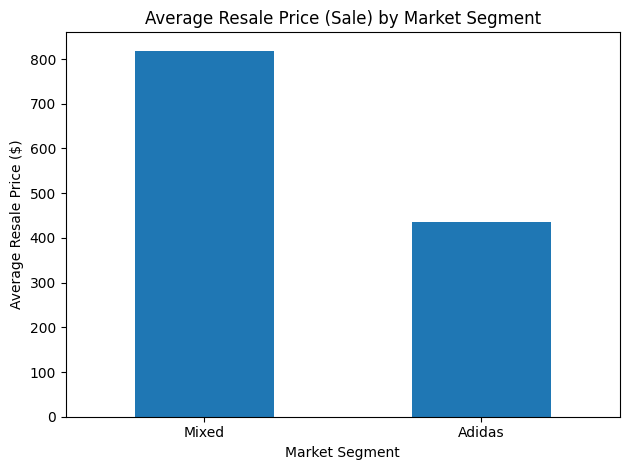

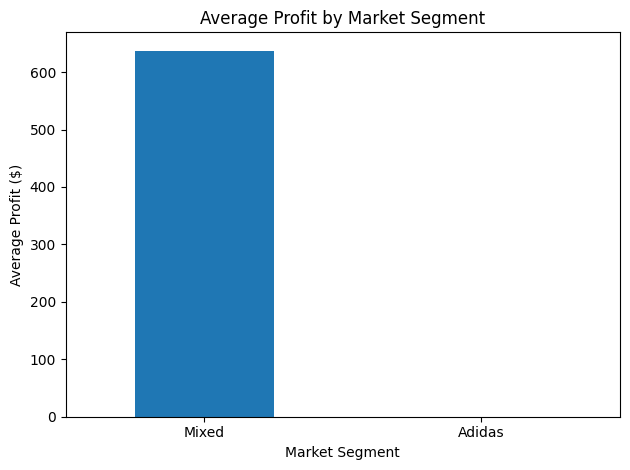

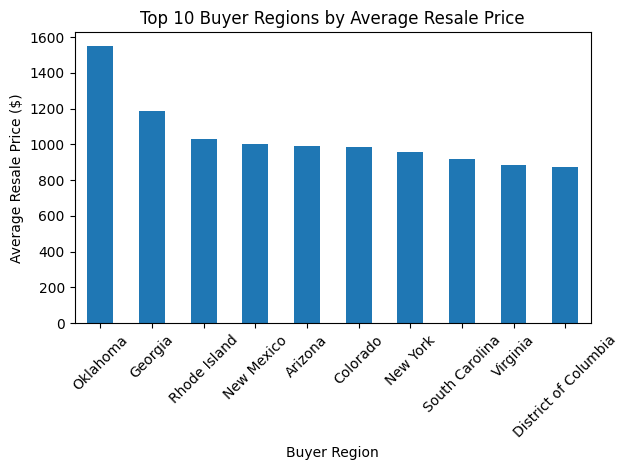

In [26]:
import matplotlib.pyplot as plt

# ==============================
# 1️⃣ Average Resale Price by Brand
# ==============================

brand_summary["avg_sale"].plot(
    kind="bar",
    title="Average Resale Price (Sale) by Market Segment"
)

plt.xlabel("Market Segment")              # <-- sửa chữ brand thành này
plt.ylabel("Average Resale Price ($)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("brand_avg_sale.png", dpi=200)
plt.show()


# ==============================
# 2️⃣ Average Profit by Brand
# ==============================

if "Profit" in master_df.columns:
    brand_summary["avg_profit"].plot(
        kind="bar",
        title="Average Profit by Market Segment"
    )

    plt.xlabel("Market Segment")          # <-- sửa ở graph 2 luôn
    plt.ylabel("Average Profit ($)")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig("brand_avg_profit.png", dpi=200)
    plt.show()


# ==============================
# 3️⃣ Top 10 Regions by Avg Sale
# ==============================

if region_summary is not None:
    region_summary["avg_sale"].head(10).plot(
        kind="bar",
        title="Top 10 Buyer Regions by Average Resale Price"
    )

    plt.xlabel("Buyer Region")
    plt.ylabel("Average Resale Price ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("region_avg_sale_top10.png", dpi=200)
    plt.show()

In [21]:
master_df.to_csv("cleaned_master_sneaker.csv", index=False)
brand_summary.to_csv("brand_summary.csv")

if top_sneakers is not None:
    top_sneakers.to_csv("top10_sneakers.csv")

if region_summary is not None:
    region_summary.to_csv("region_summary.csv")

print("Saved: cleaned_master_sneaker.csv + summaries + PNG charts")

Saved: cleaned_master_sneaker.csv + summaries + PNG charts
